# Quantum Kernel Estimator Challenge

For the first leg of the QML challenge, you implemented a variational quantum classifier (VQC) to take on a supervised learning problem based on the work of [Havlicek et al. (2018)](https://arxiv.org/pdf/1804.11326.pdf). Now, you will build on that experience, and explore Havlicek et al.'s second proposed method of applying quantum-enhanced feature spaces to machine learning: the *quantum kernel estimator*. In this challenge continuation, you will construct a QML model that estimates a kernel function using a quantum computer and optimize a classical support vector machine (SVM). For this classification protocol, we will continue to restrict ourselves to the binary label case, with $C = \left\{+1, −1\right\}$.

Compared to the VQC challenge, we are providing very little template code for this kernel estimator challenge. This is by design to enable teams to further differentiate their model, especially in the training phase. The [Havlicek et al. (2018)](https://arxiv.org/pdf/1804.11326.pdf) paper is your best resource, and the [Kernel-based training Pennylane tutorial](https://pennylane.ai/qml/demos/tutorial_kernel_based_training.html) may also be helpful. You are free to import and use any additional packages that you wish.

In [1]:
!qbraid jobs enable haqs  # enable quantum jobs

You have already enabled qBraid Quantum Jobs in the haqs environment.


In [2]:
!pip install cvxopt

In [3]:
TEAM_NAME = "CSDL"  # enter team name

In [4]:
import warnings

warnings.filterwarnings("ignore")

import csv
import json
import os
import time
from itertools import chain, combinations

import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import pennylane as qml
import pennylane.numpy as np
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

from scipy.optimize import minimize

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from matplotlib.colors import TwoSlopeNorm
from matplotlib.ticker import MaxNLocator

## Load and visualize dataset

As before, we are given data from a training set $T$ and a test set $S$ of a subset $\Omega \in \rm {I\!R}^n$. Both are assumed to be labelled by the map $m: T \cup S \rightarrow \{+1,−1\}$ unkown to the algorithm. To generate the data, two random vectors in the X-Z plane of the Bloch sphere are chosen. Around these two vectors, we randomly sample two sets of quantum data points; the task is to learn to distinguish the two sets.

In [5]:
# %run gen_binary.py  # uncomment to generate new train/test dataset

In [6]:
# Load generated dataset

DATA_PATH = "data/"

file = open(DATA_PATH + "params.json")

params = json.load(file)
delta = params["delta"]
n_points = params["n_points"]

file.close()

# Load data
Xs = np.zeros(shape=(n_points, 2))
Ys = np.zeros(shape=(n_points,))

with open(DATA_PATH + "binary_data.csv", mode="r") as file:
    csvFile = csv.reader(file)
    for i, row in enumerate(csvFile):
        Xs[i] = np.array([float(row[0]), float(row[1])])
        Ys[i] = float(row[2])
        if i == n_points:
            break

n_sets = 2
samples_per_set = 40
n_samples = n_sets * samples_per_set
X_data, Y_data = Xs[:n_samples], Ys[:n_samples]
X_train, X_test, Y_train, Y_test = train_test_split(
    X_data, Y_data, train_size=1 / n_sets
)

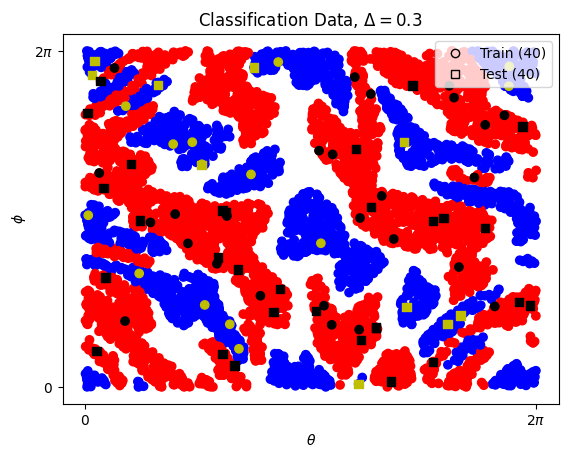

In [7]:
# Visualize generated dataset

split_xs = lambda x: [[x[i][j] for i in range(len(x))] for j in [0, 1]]

xi, xj = split_xs(Xs)
xi_train, xj_train = split_xs(X_train)
xi_test, xj_test = split_xs(X_test)

label_circle = mlines.Line2D(
    [],
    [],
    color="none",
    marker="o",
    markerfacecolor="none",
    markeredgecolor="black",
    label=f"Train ({len(X_train)})",
)
label_square = mlines.Line2D(
    [],
    [],
    color="none",
    marker="s",
    markerfacecolor="none",
    markeredgecolor="black",
    label=f"Test ({len(X_test)})",
)

plt.scatter(xi, xj, marker="o", c=["r" if v == 1.0 else "b" for v in Ys])
plt.scatter(xi_train, xj_train, c=["k" if v == 1.0 else "y" for v in Y_train])
plt.scatter(xi_test, xj_test, marker="s", c=["k" if v == 1.0 else "y" for v in Y_test])
plt.xticks([0, 2 * np.pi], [r"$0$", r"$2\pi$"])
plt.yticks([0, 2 * np.pi], [r"$0$", r"$2\pi$"])
plt.xlabel("$\\theta$")
plt.ylabel("$\phi$")
plt.legend(handles=[label_circle, label_square], loc="upper right")
plt.title(f"Classification Data, $\Delta = {delta}$")
plt.show()

An arbitrary single qubit state can be written:

$$ \left| \psi \right\rangle = e^{i \gamma} \big(\cos \frac{\theta}{2}\left|0\right\rangle+e^{i \phi} \sin \frac{\theta}{2}\left|1\right\rangle \big) $$ 

where $\theta$, $\phi$ and $\gamma$ are real numbers. The numbers $0 \leq \theta \leq \pi$ and $0 \leq \phi \leq 2\pi$ define a point on the Bloch sphere.

## Quantum Feature Map

Quantum kernel function which generates nonlinear feature map. Figure 1.B and 1.C in [Havlíček et al. (2018)](https://arxiv.org/pdf/1804.11326.pdf).

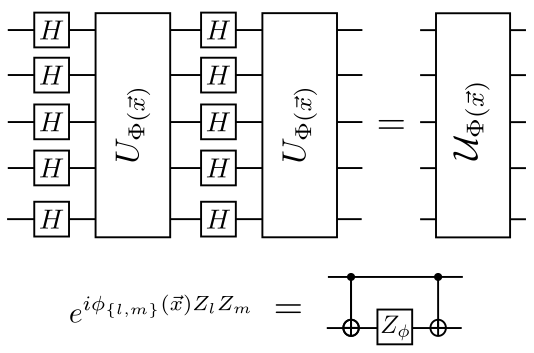

In [8]:
def powerset(iterable, mx):
    """
    Examples:
        powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)
        powerset([1,2,3], 2) --> (1,2), (1,3), (2,3)
    """
    s = list(iterable)
    pset = chain.from_iterable(combinations(s, r) for r in range(len(s) + 1))
    return [l for l in list(pset) if len(l) == mx]

In [9]:
def encode_data(x):
    """Non-linear encoding (transformation) of one input data vector

    Args:
        x : shape (2,) tensor containing one input data vector

    Returns:
        triple of data encoded coefficients phi_1, phi_2, phi_{1,2}
    """

    return x[0], x[1], (np.pi - x[0]) * (np.pi - x[1])

Considering only Ising type interactions ($d=2$), the unitaries are generated from one- and two- big gates of the form

$$U_{\phi_{\{k\}}(\textbf{x})} = \exp\big(i\phi_{\{k\}}(\textbf{x})Z_k \big)$$
$$U_{\phi_{\{l,m\}}(\textbf{x})} = \exp\big(i\phi_{\{k,l\}}(\textbf{x})Z_kZ_l\big)$$

where we have followed Havlíček et al. and chosen $\phi_{\{ i \}} = x_i$ and $\phi_{\{ 1,2 \}} = (\pi - x_1)(\pi-x_2)$ 

In [10]:
n_wires = 2  # number of qubits
S_size = 2  # number of interactions considered
pset = powerset(range(n_wires), S_size)

In [11]:
def embedding(x):
    """The embedding ansatz

    Args:
        x : shape (3,) tensor containing one encoded data vector

    """

    for i in range(n_wires):
        qml.RZ(2 * x[i], wires=i)
    
    for s in pset:
        qml.CNOT(wires=s)
        qml.RZ(2 * x[-1], wires=s[-1])
        qml.CNOT(wires=s)

## Quantum kernel (ideal)

Ideal quantum kernel. Figure S5.B in [Havlíček et al. (2018)](https://arxiv.org/pdf/1804.11326.pdf). <br>
This circuit estimates the fidelity between two states, $x$ and $z$, in the feature space. <br>
Note that the measurement blocks are not included. Instead, we calculate the exact expecation value.

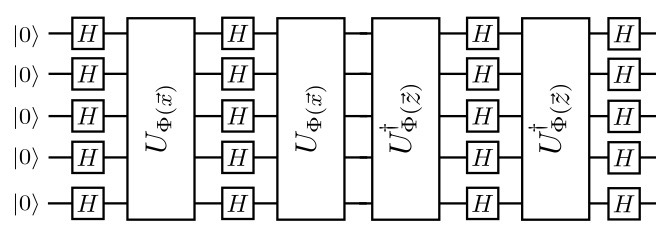

In [12]:
dev_kernel = qml.device("default.qubit", wires=n_wires)

projector = np.zeros((2**n_wires, 2**n_wires))
projector[0, 0] = 1


@qml.qnode(dev_kernel)
def kernel(x, z):
    """Compute quantum kernel element for two feature vectors.

    Args:
        x : shape (2,) tensor containing one input data vector
        z : shape (2,) tensor containing one input data vector

    """

    x_enc = encode_data(x)
    z_enc = encode_data(z)

    for _ in range(S_size):
        for i in range(n_wires):
            qml.Hadamard(wires=i)
        embedding(x_enc)

    for _ in range(S_size):
        qml.adjoint(embedding)(z_enc)
        for i in range(n_wires):
            qml.Hadamard(wires=i)

    return qml.expval(qml.Hermitian(projector, wires=range(n_wires)))

In [13]:
def kernel_ideal(A, B):
    """Ideal kernel matrix for sets A and B."""
    return np.array([[kernel(a, b) for b in B] for a in A])

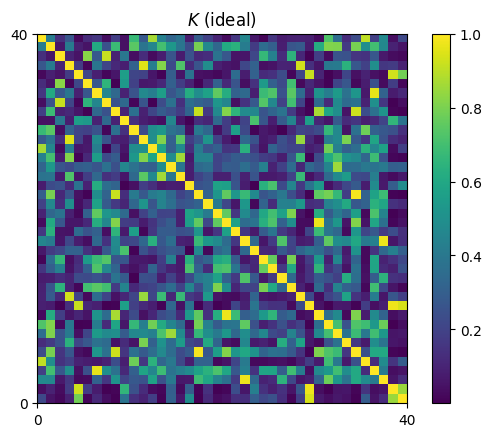

In [14]:
# Visualize ideal kernel matrix containing the inner products of all
# data points used for training, c.f. Havlicek Fig. 4.a (right)

k_ideal = kernel_ideal(X_train, X_train)

im = plt.imshow(k_ideal, extent=(0, samples_per_set, 0, samples_per_set))
plt.colorbar(im)
plt.xticks([0, samples_per_set])
plt.yticks([0, samples_per_set])
plt.title("$K$ (ideal)")
plt.show()

## Quantum kernel estimator

Here it will be convenient to write $T = \left\{\textbf{x}_1,...,\textbf{x}_t\right\}$ with $t = \left|T\right|$; also let $y_i = m(\textbf{x}_i)$ be the corresponding label. In this protocol you will use a quantum computer to estimate the $t \times t$ kernel matrix $K(\textbf{x}_i, \textbf{x}_j) = \left|\langle\Phi(\textbf{x}_i)|\Phi(\textbf{x}_j)\rangle\right|^2$. For all pairs of points $\textbf{x}_i, \textbf{x}_j \in T$ in the the training data, you will sample the overlap between feature states to obtain the matrix entry in the kernel. This fidelity can be estimated from the output probability of the circuit by sampling the output distribution with $R$ shots and only taking the $0^n$ count. The frequency of the $0^n$ count is an estimator of the Kernel entry up to an error $\epsilon = O(R^{−1/2})$. After the kernel matrix for the full training data has been constructed we use the conventional (classical) support vector machine classifier. The optimal hyperplane can be found by solving the dual quadratic program $L_D$ for the variables $\alpha = \left\{\alpha_i\right\}_{i=1...t}$. Hence, to train, we maximize

\begin{equation}
L_D(\alpha) = \sum_{i=1}^t \alpha_i - \frac{1}{2}\sum_{i,j=1}^t y_i y_j \alpha_i \alpha_j K(\textbf{x}_i, \textbf{x}_j),
\label{eq:Ld} \tag{1}
\end{equation}

subject to $\sum_{i=1}^t \alpha_i y_i = 0$ and $\alpha_i \geq 0$. This problem is concave, and therefore efficiently solvable, whenever $K(\textbf{x}_i, \textbf{x}_j)$ is a positive definite matrix. Standard quadratic programming solvers can be used. The solution to this problem will be given by a nonnegative vector $\alpha^* = (\alpha_1^*,...,\alpha_t^*)$. Due to complementary slackness, we expect that many of the $\alpha_i^*$ will be zero. Hence, there will only be subset of training samples that are needed to construct the optimal hyperplane. These samples are referred to as the support vectors.


### 1) Training Phase

The training phase consists of the following steps:

---
### Algorithm 1: training
1. **Input** Labeled training samples $T = \left\{ \textbf{x} \in \Omega \in {\rm I\!R}^n \right\} \times \left\{ y \in C \right\}$, quadratic program solver.
2. **Parameters** Number of measurement shots $R$.
3. Calibrate the quantum hardware to generate short depth circuits.
4. **for** $\textit{i} = 1$ to $\textit{t}$ **do**
5. $\hspace{5mm}$ **for** $\textit{j} = 1$ to $\textit{t}$ **do**
6. $\hspace{10mm}$ Set the counter $r_{0^n} = 0$
7. $\hspace{10mm}$ **for** $\textit{shot} = 1$ to $R$ **do**
8. $\hspace{15mm}$ Run the circuit from Havlicek Fig. 2.c. with paremeters $\textbf{x}_i, \textbf{x}_j$.
9. $\hspace{15mm}$ Measure outcome in $Z$-basis.
10. $\hspace{15mm}$ **if** Measurement outcome is $0^n$ **then**
11. $\hspace{20mm}$ Increase counter by one, setting $r_{0^n} \rightarrow r_{0^n} + 1$.
12. $\hspace{15mm}$ **end if**
13. $\hspace{10mm}$ **end for**
14. $\hspace{10mm}$ Construct kernel estimate $\hat{K}(\textbf{x}_i, \textbf{x}_j) = r_{0^n}R^{-1}$.
15. $\hspace{5mm}$ **end for**
16. **end for**
17. Use quadratic program solver to optimize $\alpha$ in $L_D$ in eqn. (1) with kernel $K = \hat{K}$ and set $T$.
18. **return** the final parameters $\alpha^*$ and value of the cost function $L_D$ and kernel estimator $\hat{K}$.
---

Quantum kernel estimation. Figure S5.B in [Havlíček et al. (2018)](https://arxiv.org/pdf/1804.11326.pdf). <br>
Caculate the probability by measuring the output multiple times.

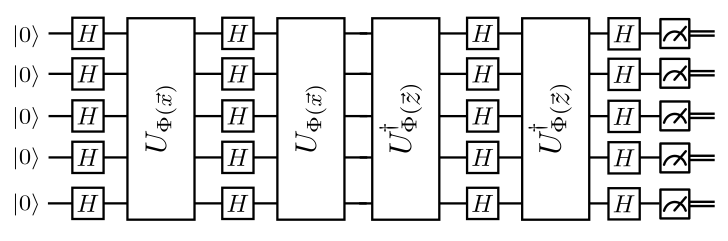

In [15]:
shots = 1000

dev_est = qml.device("default.qubit", wires=n_wires, shots=shots)


def fidelity_estimate(x, z):
    """Directly estimate the fidelity between a pair of feature vectors for data `x` and `z`

    Args:
        x : shape (2,) tensor containing one input data vector
        z : shape (2,) tensor containing one input data vector

    Returns:
        shape (2, `R`) tensor containing `R` Z-basis measurement samples on each qubit, where `R` 
        is the number of shots determined from the dev.shots attribute of the corresponding device.
    """
    
    @qml.qnode(dev_est)
    def circuit(x, z):
        """Inner function which returns shape (`R`, 2) tensor"""
        x_enc = encode_data(x)
        z_enc = encode_data(z)

        for _ in range(S_size):
            for i in range(n_wires):
                qml.Hadamard(wires=i)
            embedding(x_enc)

        for _ in range(S_size):
            qml.adjoint(embedding)(z_enc)
            for i in range(n_wires):
                qml.Hadamard(wires=i)
                
        return qml.sample()  # shape (`R`, 2)
    
    return circuit(x, z).T  # shape (2, `R`)

In [16]:
def get_single_estimation(a, b):
    """Line 6 to 14 of Algorithm 1 / Line 5 to 13 of Algorithm 2"""
    meas = fidelity_estimate(a, b)
    allzeros = ~np.any(meas, axis=0)
    counts = np.sum(allzeros)
    return counts / shots

def kernel_experimental(A, B):
    """Experimentally estimated kernel matrix for sets A and B."""
    return np.array([[get_single_estimation(a, b) for b in B] for a in A])

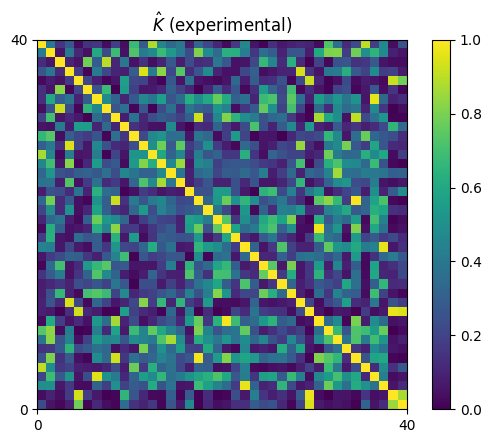

In [17]:
# Visualize experimental kernel matrix containing the inner products of all
# data points used for training, c.f. Havlicek Fig. 4.a (left)

k_experimental = kernel_experimental(X_train, X_train)

im = plt.imshow(k_experimental, extent=(0, samples_per_set, 0, samples_per_set))
plt.colorbar(im)
plt.xticks([0, samples_per_set])
plt.yticks([0, samples_per_set])
plt.title("$\hat{K}$ (experimental)")
plt.show()

### Comparison: $K$ (ideal) and $\hat{K}$ (experimental)

To evaluate how accurate the kernel estimation is, let's take a look at the absolute difference of $K$ and $\hat{K}$.


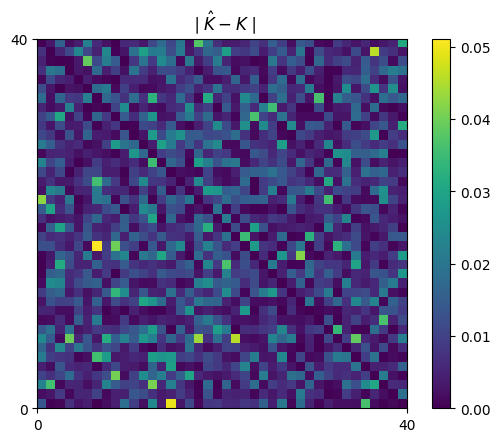

In [18]:
k_diff = np.abs(k_experimental - k_ideal)

im = plt.imshow(k_diff, extent=(0, samples_per_set, 0, samples_per_set))
plt.colorbar(im)
plt.xticks([0, samples_per_set])
plt.yticks([0, samples_per_set])
plt.title("$\mid \hat{K}-K \mid$")
plt.show()

Let's take the worst case of estimation, which means the row with a maximal abolute difference. <br>
The figure shown below is the comparison of the worst case row. <br>
As you can see, we can get sufficient precision for probability distribution only with 1000 shots.

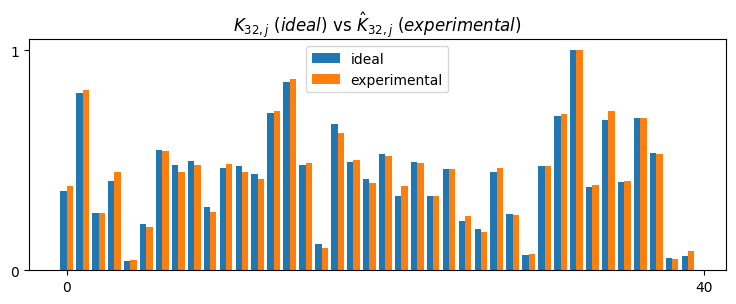

In [19]:
# Get index of the row with maximum difference
idx_max_diff = np.argmax(k_diff.sum(axis=1))
row_ideal = k_ideal[idx_max_diff]
row_experimental = k_experimental[idx_max_diff]

# Draw difference plot
x_axis = np.arange(len(k_diff))
plt.figure(figsize=(9, 3))
plt.bar(x_axis-0.2, row_ideal, 0.4, label='ideal')
plt.bar(x_axis+0.2, row_experimental, 0.4, label='experimental')
plt.xticks([0, samples_per_set])
plt.yticks([0, 1])
index_string = f'{idx_max_diff}, j'
plt.title('$K_{%s} \\ (ideal) \\ \\mathrm{vs} \\ \\hat{K}_{%s} \\ (experimental) $' %(index_string, index_string))
plt.legend()
plt.show()

### Solve Quadratic Program with CVXOPT

The standard form of the quadratic program (QP) is given as follow:

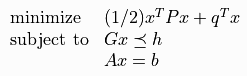

Considering the target variable $x$ as $\alpha$, we need to construct 6 matrices, $P$, $q$, $G$, $h$, $A$, $b$.
- $P$ and $q$ express the objective fuction of the problem.
- $G$ and $h$ express the inequality constraints of the problem.
- $A$ and $b$ express the equality constraints of the problem.

First, transform the $L_D(\alpha)$ into a matrix-vector form.


\begin{equation}
\begin{split}
L_D(\alpha) & = \sum_{i=1}^t \alpha_i - \frac{1}{2}\sum_{i,j=1}^t y_i y_j \alpha_i \alpha_j K(\textbf{x}_i, \textbf{x}_j) \\ 
& = \begin{pmatrix}
    1 & 1 & \cdots & 1 
\end{pmatrix} \begin{pmatrix}
    \alpha_1 \\ \alpha_2 \\ \vdots \\ \alpha_t \\
\end{pmatrix} - \dfrac{1}{2} \begin{pmatrix}
    \alpha_1 & \alpha_2 & \cdots & \alpha_t 
\end{pmatrix} \begin{pmatrix}
    y_1 y_1 K(x_1, x_1) & y_1 y_2 K(x_1, x_2) & \cdots & y_1 y_t K(x_1, x_t) \\ 
    y_2 y_1 K(x_2, x_1) & y_2 y_2 K(x_2, x_2) & \cdots & y_2 y_t K(x_2, x_t) \\ 
    \vdots & \vdots & \ddots & \vdots \\
    y_t y_1 K(x_t, x_1) & y_t y_2 K(x_t, x_2) & \cdots & y_t y_t K(x_t, x_t)
\end{pmatrix} \begin{pmatrix}
    \alpha_1 \\ \alpha_2 \\ \vdots \\ \alpha_t \\
\end{pmatrix} \\
& = 1^T \alpha - \dfrac{1}{2} \alpha^T (Y \odot K) \alpha \quad \text{where} \ Y = yy^T \ \text{and} \ \odot \text{ is element-wise multiplication.}
\end{split}
\end{equation}


Since the standard form of the QP is to *minimize* the objective function, the problem becames as follows (omitted constraints for clarity):

\begin{equation}
    \max_{\alpha} L_D(\alpha) 
    \Leftrightarrow \min_{\alpha} -L_D(\alpha)
    \Leftrightarrow \min_{\alpha} \dfrac{1}{2} \alpha^T (Y \odot K) \alpha - 1^T \alpha
\end{equation}

Therefore, we obtain
$$
P = Y \odot K \ , \ \ q = -1 \in \mathbb{R}^t
$$

Then, we have inequality contraint $\forall i \ \alpha_i \geq 0$ and equality constraint $\sum_{i=1}^{t} \alpha_i y_i = 0$

$$
\forall i \ \alpha_i \geq 0 \ \Leftrightarrow \ I \alpha \succeq 0 \ \Leftrightarrow \ -I \alpha \preceq 0 \\
\sum_{i=1}^{t} \alpha_i y_i = 0 \ \Leftrightarrow \ y^T \alpha = 0. 
$$
Therefore, we get 
$$
G = -I \ , \ \ h = 0 \in \mathbb{R}^t \ , \ \ A = y^T \ , \ \ b = 0
$$

In [20]:
# TODO: Implement training algorithm
from cvxopt import matrix, solvers

y = Y_train.reshape((-1, 1))

P = matrix((y @ y.T) * k_experimental)
q = matrix(-np.ones(samples_per_set))

G = matrix(-np.eye(samples_per_set))
h = matrix(np.zeros(samples_per_set))

A = matrix(y.T)
b = matrix([0.0])

sol = solvers.qp(P, q, G, h, A, b)

alpha = np.array(sol['x']).squeeze()

     pcost       dcost       gap    pres   dres
 0: -7.5947e+00 -2.1345e+01  8e+01  7e+00  2e+00
 1: -8.1099e+00 -1.9155e+01  2e+01  8e-01  2e-01
 2: -1.0581e+01 -1.4247e+01  4e+00  2e-01  5e-02
 3: -1.2184e+01 -1.3631e+01  2e+00  5e-02  1e-02
 4: -1.3000e+01 -1.3079e+01  8e-02  2e-03  4e-04
 5: -1.3048e+01 -1.3049e+01  1e-03  2e-05  6e-06
 6: -1.3048e+01 -1.3048e+01  1e-05  2e-07  6e-08
 7: -1.3048e+01 -1.3048e+01  1e-07  2e-09  6e-10
Optimal solution found.


### 2) Classification Phase

In the classification phase, we want to assign a label to a new datum $s \in S$ of the test set. For this, the inner products $K(\textbf{x}_i, \textbf{s})$ between all support vectors $\textbf{x}_j \in T$ with $\alpha_i^* > 0$ and the new datum s have to be estimated on the quantum computer, c.f. Havlicek Fig. S5.b. The new label $\tilde{m}(\textbf{s})$ for the datum is assigned according to Havlicek eqn. (14). Since all support vectors are known from the training phase and we have obtained access to the kernel $K(\textbf{x}_i,\textbf{s})$ from the quantum hardware, the label can be directly computed according to


\begin{equation}
\tilde{m}(\textbf{s}) = \text{sign} \bigg(\sum_{i=1}^t y_i \alpha_i^* K(\textbf{x}_i, \textbf{s}) + b \bigg).
\label{eq:ms} \tag{2}
\end{equation}

Note that the bias $b$ in $\tilde{m}(\textbf{s})$ can be calculated from the weights $\alpha_i^*$ by choosing any $i$ with $\alpha_i^* > 0$ and solving $\sum_j y_j \alpha_j^* K(\textbf{x}_j, \textbf{x}_i) + b = y_i$ for $b$.

---
### Algorithm 2: classification
1. **Input** An unlabeled sample from the test set $\textbf{s} \in S$, optimal SVM parameters $\alpha, b$ and training data set $T$. 
2. **Parameters** Number of measurement shots $R$.
3. Calibrate the quantum hardware to generate short depth circuits.
4. **for** $\textit{i} = 1$ to $\textit{t}$ with $\alpha_i^* > 0$ **do**
5. $\hspace{5mm}$ Set the counter $r_{0^n} = 0$
7. $\hspace{5mm}$ **for** $\textit{shot} = 1$ to $R$ **do**
8. $\hspace{10mm}$ Run the circuit from Havlicek Fig. 2.c. with paremeters $\textbf{x}_i, \textbf{s}$.
9. $\hspace{10mm}$ Measure outcome in $Z$-basis.
10. $\hspace{10mm}$ **if** Measurement outcome is $0^n$ **then**
11. $\hspace{15mm}$ Increase counter by one, setting $r_{0^n} \rightarrow r_{0^n} + 1$.
12. $\hspace{10mm}$ **end if**
13. $\hspace{5mm}$ **end for**
14. $\hspace{5mm}$ Construct kernel estimate $\hat{K}(\textbf{x}_i, \textbf{s}) = r_{0^n}R^{-1}$.
15. **end for**
16. **return** $\text{sign}\big(\sum_{i=1}^t y_i \alpha_i^* \hat{K}(\textbf{x}_i, \textbf{s}) + b \big)$.
---

In [21]:
# TODO: Implement classification algorithm
def forward(s, b):
    K = np.array([get_single_estimation(x, s) for x in X_train])
    m = np.sum(Y_train * alpha * K) + b
    return m

# choose i and calculate bias b
nonzeros = np.where(alpha > 1e-5)[0]
i = int(np.random.choice(nonzeros, 1))
b = Y_train[i] - forward(X_train[i], 0)

# make prediction
def predict(s):
    m = forward(s, b)
    return m

predictions = np.array([predict(s) for s in X_test])
pred_labels = np.sign(predictions)

In [22]:
###### TODO: Test accuracy
acc = accuracy_score(pred_labels, Y_test, normalize=True)
print(f"Accuracy of Quantum Kernel Estimation method: {acc * 100}%")

Accuracy of Quantum Kernel Estimation method: 100.0%


### Visualization of prediction
The output value (prediction) of the classifier expresses the distance between a data point and the hyperplane with sign in the kernel space. <br>
Therefore, we can use it to visualize the optimal hyperplane on the 1D output space with value 0. <br>
As you can see in the figure shown below, the vertical line at 0 (the projection of hyperplane on output space) exactly seperates the data.

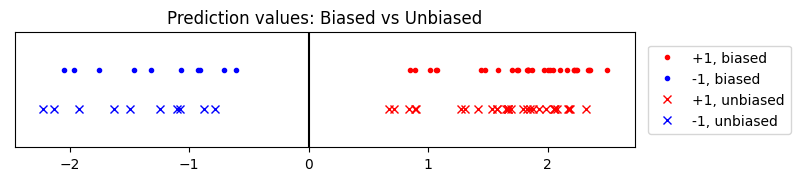

In [23]:
biased_output = predictions
unbiased_output = predictions - b

biased_plus = biased_output[Y_test >= 0]
biased_minus = biased_output[Y_test < 0]
unbiased_plus = unbiased_output[Y_test >= 0]
unbiased_minus = unbiased_output[Y_test < 0]

plt.figure(figsize=(8, 1.5))
plt.plot(biased_plus, np.ones_like(biased_plus), 'r.', label='+1, biased')
plt.plot(biased_minus, np.ones_like(biased_minus), 'b.', label='-1, biased')
plt.plot(unbiased_plus, np.zeros_like(unbiased_plus), 'rx', label='+1, unbiased')
plt.plot(unbiased_minus, np.zeros_like(unbiased_minus), 'bx', label='-1, unbiased')
plt.axvline(0, color='k')
plt.ylim([-1, 2])
plt.yticks([])
plt.title('Prediction values: Biased vs Unbiased')
plt.legend(bbox_to_anchor=(1.01, 0.5), loc="center left")
plt.show()

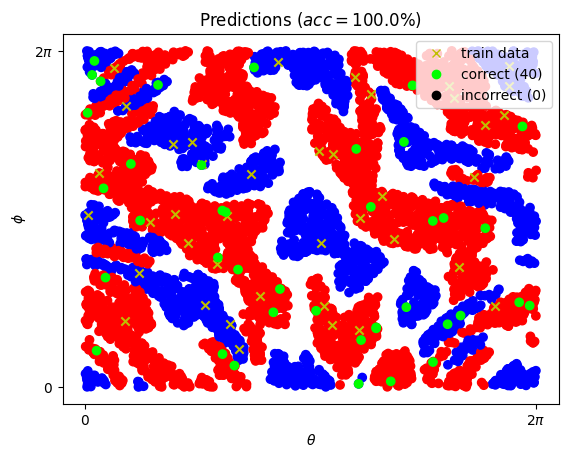

In [24]:
time_str = time.strftime("%Y%m%d-%H%M%S")
KER_OUT = f"ker/{time_str}"
os.makedirs(KER_OUT, exist_ok=True)

preds = (pred_labels == Y_test)
n_preds = len(preds)
n_correct = sum(preds)
n_incorrect = n_preds - n_correct

# Plot predictions
preds_png = f"{KER_OUT}/{TEAM_NAME}_preds.png"

config = [
    ('x', 'y', f'train data'),
    ('o', 'lime', f'correct ({n_correct})'),
    ('o', 'k', f'incorrect ({n_incorrect})'),
]

handles = [
    mlines.Line2D(
        [],
        [],
        color="none",
        marker=marker,
        markerfacecolor=color,
        markeredgecolor=color,
        label=label,
    ) for marker, color, label in config
]

plt.scatter(xi, xj, marker="o", c=["r" if v == 1.0 else "b" for v in Ys])
plt.scatter(xi_train, xj_train, marker="x", c="y", label='train')
plt.scatter(xi_test, xj_test, c=["lime" if v else "k" for v in preds])
plt.xticks([0, 2 * np.pi], [r"$0$", r"$2\pi$"])
plt.yticks([0, 2 * np.pi], [r"$0$", r"$2\pi$"])
plt.xlabel("$\\theta$")
plt.ylabel("$\phi$")
plt.legend(handles=handles, loc="upper right")
plt.title(f"Predictions ($acc = {acc * 100}\%$)")
plt.savefig(preds_png)
plt.show()

### Visualization of the optimal seperating hyperplane

We have calculated the optimal hyperplane by solving quadratic program, and finding appropriate bias. <br>
Also, we showed that this hyperplane seperates the test data with 100% accuracy. <br>
Now, let's visualize this optimal seperating hyperplane on the input space. <br>
The projection of the hyperplane on the input space can be visualized with the contour of the predictions.

In [25]:
# make `num_samples` larger to increase the resolution
num_samples = 50
sampling_points = np.linspace(0, 2*np.pi, num_samples)

# generate 2 2d grids for the x & y bounds
x, y = np.meshgrid(sampling_points, sampling_points)

In [26]:
# generate 2d grid for the z values
z = np.empty_like(x)

for i in tqdm(range(num_samples)):
    for j in range(num_samples):
        point = np.array([x[i, j], y[i, j]])
        z[i, j] = predict(point)        

  0%|          | 0/50 [00:00<?, ?it/s]

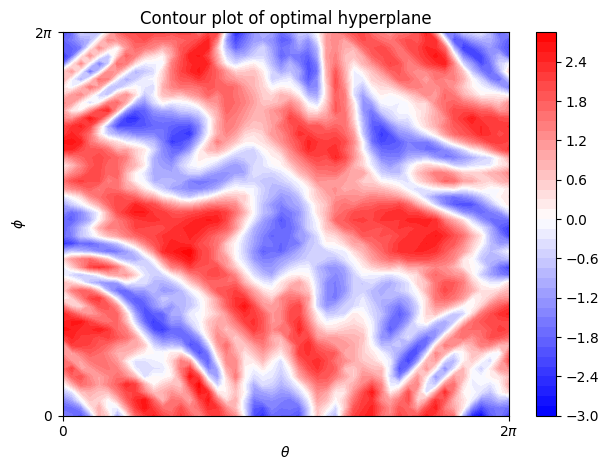

In [27]:
# make a contour plot of the experimental kernel
levels = MaxNLocator(nbins=50).tick_values(z.min(), z.max())
cmap = plt.get_cmap('bwr')
norm = TwoSlopeNorm(vcenter=0)

plt.contourf(x, y, z, levels=levels, cmap=cmap, norm=norm)
plt.xticks([0, 2 * np.pi], [r"$0$", r"$2\pi$"])
plt.yticks([0, 2 * np.pi], [r"$0$", r"$2\pi$"])
plt.xlabel("$\\theta$")
plt.ylabel("$\phi$")
plt.colorbar()
plt.title('Contour plot of optimal hyperplane')
plt.tight_layout()
plt.show()

In the figure, the region with white color represents the optimal hyperplane.<br>
Moreover, you can see that the kernel method reconstructed the full distribution of original data even with few training data. <br>

## Fidelity estimation using SWAP test 

SWAP test circuit. Figure S5.A in [Havlíček et al. (2018)](https://arxiv.org/pdf/1804.11326.pdf).<br>
The usual method of estimating the fidelity between two states is by using the swap test. <br>
This circuit evaluates the expectation value $\langle\psi|\langle\phi| SWAP |\psi\rangle|\phi\rangle$ directly.

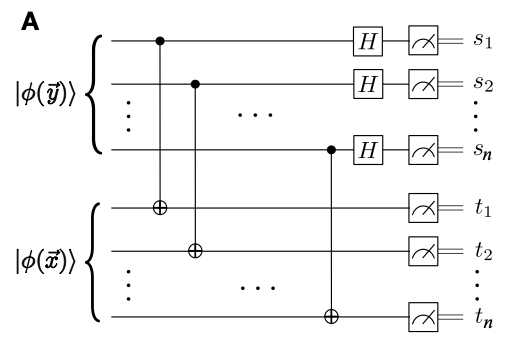

Since $ SWAP_{ij} = CNOT_{i\rightarrow j} CNOT_{j\rightarrow i} CNOT_{i\rightarrow j}$ and $CNOT_{j\rightarrow i} = H_j CZ_{ji} H_i$, <br>
we can see that $SWAP_{ij}$ is diagonalized by $CNOT_{j\rightarrow i} H_j$ and has eigenvalue $(-1)^{x_i x_j}$.

Therefore, the output is the average ot the boolean function $f(s, t) = (-1)^{(s_1 t_1 + \cdots + s_n t_n)}$, where $s\in{0, 1}^n$ and $t\in{0, 1}^n$.


In [28]:
shots = 1000

dev_swap_test = qml.device("default.qubit", wires=2*n_wires, shots=shots)


def swap_test_circuit(x, z):
    """Directly estimate the fidelity between a pair of feature vectors for data `x` and `z`

    Args:
        x : shape (2,) tensor containing one input data vector
        z : shape (2,) tensor containing one input data vector

    Returns:
        shape (4, `R`) tensor containing `R` Z-basis measurement samples on each qubit, where `R` 
        is the number of shots determined from the dev.shots attribute of the corresponding device.
    """
    
    @qml.qnode(dev_swap_test)
    def circuit(x, z):
        """Inner function which returns shape (`R`, 4) tensor"""
        x_enc = encode_data(x)
        z_enc = encode_data(z)
        
        # embedding 
        for _ in range(n_wires):
            for i in range(2*n_wires):
                qml.Hadamard(wires=i)
            
            # embedding of z
            for i in range(n_wires):
                qml.RZ(2 * z_enc[i], wires=i)
            for s in powerset(list(range(n_wires)), 2):
                qml.CNOT(wires=s)
                qml.RZ(2 * z_enc[-1], wires=s[-1])
                qml.CNOT(wires=s)
            
            # embedding of x
            for i in range(n_wires):
                qml.RZ(2 * x_enc[i], wires=i+n_wires)
            for s in powerset(list(range(n_wires, 2*n_wires)), 2):
                qml.CNOT(wires=s)
                qml.RZ(2 * x_enc[-1], wires=s[-1])
                qml.CNOT(wires=s)
            
        # SWAPs
        for i in range(n_wires):
            qml.CNOT(wires=[i, i+n_wires])
        for i in range(n_wires):
            qml.Hadamard(wires=i)
        
        return qml.sample()  # shape (`R`, 4)
    
    return circuit(x, z).T  # shape (4, `R`)

def swap_test(x, z):
    m = swap_test_circuit(x, z)
    st = np.array([
        m[i, :] * m[i+n_wires, :]
        for i in range(n_wires)
    ]).sum(axis=0)
    f = 1 - 2 * (st % 2)
    return f.mean()

def kernel_swap_test(A, B):
    return np.array([[swap_test(a, b) for b in B] for a in A])

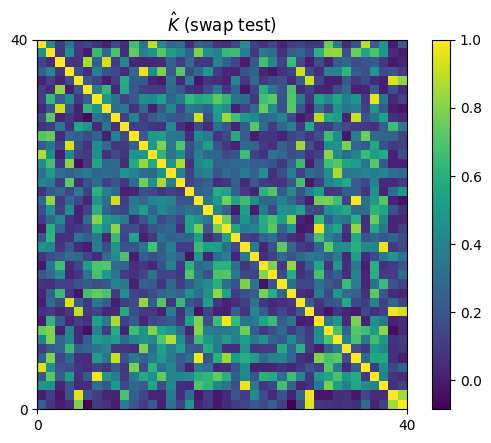

In [29]:
k_swap_test = kernel_swap_test(X_train, X_train)

im = plt.imshow(k_swap_test, extent=(0, samples_per_set, 0, samples_per_set))
plt.colorbar(im)
plt.xticks([0, samples_per_set])
plt.yticks([0, samples_per_set])
plt.title("$\hat{K}$ (swap test)")
plt.show()

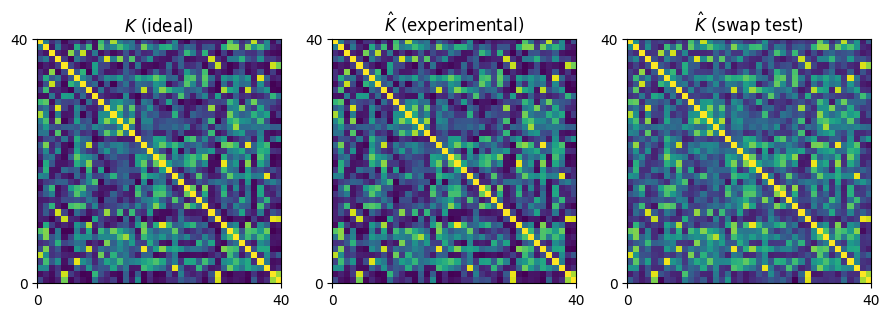

In [30]:
plt.figure(figsize=(9, 4))

plt.subplot(1, 3, 1)
im = plt.imshow(k_ideal, extent=(0, samples_per_set, 0, samples_per_set))
plt.xticks([0, samples_per_set])
plt.yticks([0, samples_per_set])
plt.title("$K$ (ideal)")

plt.subplot(1, 3, 2)
im = plt.imshow(k_experimental, extent=(0, samples_per_set, 0, samples_per_set))
plt.xticks([0, samples_per_set])
plt.yticks([0, samples_per_set])
plt.title("$\hat{K}$ (experimental)")

plt.subplot(1, 3, 3)
im = plt.imshow(k_swap_test, extent=(0, samples_per_set, 0, samples_per_set))
plt.xticks([0, samples_per_set])
plt.yticks([0, samples_per_set])
plt.title("$\hat{K}$ (swap test)")

plt.tight_layout()
plt.show()

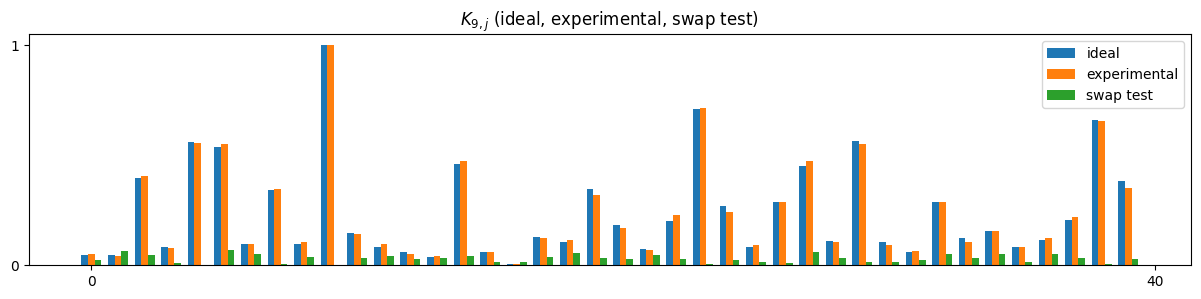

In [31]:
# Get index of the row with maximum difference
k_swap_diff = np.abs(k_ideal - k_swap_test)
idx_max_diff = np.argmax(k_swap_diff.sum(axis=1))

row_ideal = k_ideal[idx_max_diff]
row_experimental = k_experimental[idx_max_diff]
row_swap_test = k_swap_diff[idx_max_diff]

# Draw difference plot
x_axis = np.arange(len(k_diff))
plt.figure(figsize=(15, 3))
plt.bar(x_axis-0.25, row_ideal, 0.25, label='ideal')
plt.bar(x_axis, row_experimental, 0.25, label='experimental')
plt.bar(x_axis+0.25, row_swap_test, 0.25, label='swap test')
plt.xticks([0, samples_per_set])
plt.yticks([0, 1])
index_string = f'{idx_max_diff}, j'
plt.title('$K_{%s}$ (ideal, experimental, swap test)' %(index_string))
plt.legend()
plt.show()

As you can see in the figure, the kernel made by swap test circuit shows huge gap compared to the ideal and experimental.<br>
This is because the swap test circuit has twice more qubits, and more CNOT gates, resulting in larger error.